In [ ]:
import random
from keras.api.layers import *
from keras.api.optimizers import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import layers, Sequential
import cv2
import os
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.api.models import Sequential
from keras.api.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.api.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from warnings import filterwarnings
filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

directory_path = '/content/drive/My Drive/Datasets'

if os.path.exists(directory_path):
    print("Klasör mevcut!")
else:
    print("Klasör mevcut değil.")

Klasör mevcut!


In [ ]:
# Test ve eğitim görüntülerinin array'lere atanması:

X_train = []
y_train = []
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']


image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/My Drive/Datasets/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

X_test = []
y_test = []
for i in labels:
    folderPath = os.path.join('/content/drive/My Drive/Datasets/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


100%|██████████| 74/74 [00:16<00:00,  4.59it/s]


In [ ]:
from sklearn.utils import shuffle

# Test verilerini karıştırıyoruz
X_train, y_train = shuffle(X_train, y_train, random_state=101)


y_train_new = [labels.index(i) for i in y_train]
y_test_new = [labels.index(i) for i in y_test]


In [ ]:
# Kategorik verileri sayısala dönüştürüyoruz
y_train = tf.keras.utils.to_categorical(y_train_new)
y_test = tf.keras.utils.to_categorical(y_test_new)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# MobileNetV2 modelinin tanımlanması
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = True
for layer in base_model.layers[:-30]:
        layer.trainable = False # son 30 katmanı eğitip diğerlerini donduruyoruz

model = Sequential([
        base_model,  # MobileNetV2 temel modeli
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(4, activation='softmax')
    ])

# Modeli derleme
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Erken durdurma tanımlaması
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-7
)

# Modeli eğitme
history = model.fit(X_train, y_train, batch_size=32, epochs=20,
                    callbacks=[early_stopping, lr_scheduler],
                    validation_data=(X_test, y_test))

model.summary()

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 131ms/step - accuracy: 0.3090 - loss: 1.6873 - val_accuracy: 0.1853 - val_loss: 2.0105 - learning_rate: 1.0000e-05
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4600 - loss: 1.2755 - val_accuracy: 0.1954 - val_loss: 2.0075 - learning_rate: 1.0000e-05
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5503 - loss: 1.0700 - val_accuracy: 0.2107 - val_loss: 1.9634 - learning_rate: 1.0000e-05
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6100 - loss: 0.9344 - val_accuracy: 0.2132 - val_loss: 1.8895 - learning_rate: 1.0000e-05
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6697 - loss: 0.8087 - val_accuracy: 0.2360 - val_loss: 1.7809 - learning_rate: 1.0000e-05
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6994 - loss: 0.7675 - val_accuracy: 0.2665 - val_loss: 1.6895 - learning_rate: 1.0000e-05
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.701

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,864,014 (22.37 MB)

 Trainable params: 1,709,956 (6.52 MB)

 Non-trainable params: 734,144 (2.80 MB)

 Optimizer params: 3,419,914 (13.05 MB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Weighted F1 Score (Initial): 0.5641

Classification Report (Base Model):
                  precision    recall  f1-score   support

    glioma_tumor       0.69      0.09      0.16       100
        no_tumor       0.54      0.92      0.69       105
meningioma_tumor       0.64      0.73      0.68       115
 pituitary_tumor       0.77      0.74      0.76        74

        accuracy                           0.62       394
       macro avg       0.66      0.62      0.57       394
    weighted avg       0.65      0.62      0.56       394



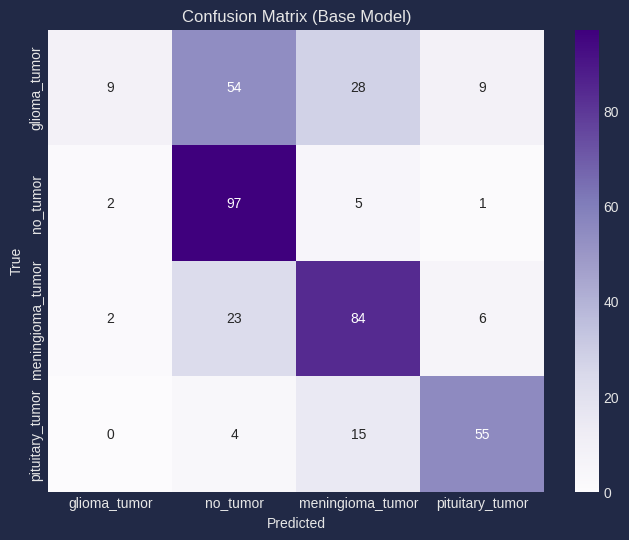

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score

y_pred = model.predict(X_test)  # Modelin test verisi üzerindeki tahminleri
y_pred_classes = np.argmax(y_pred, axis=1)  # Tahmin edilen sınıflar (0, 1, 2, 3)
y_test_classes = np.argmax(y_test, axis=1)

# F1 skoru
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print(f"\nWeighted F1 Score (Initial): {f1:.4f}")

# Classification report
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
print("\nClassification Report (Base Model):")
print(classification_report(y_test_classes, y_pred_classes, target_names=labels))

# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (Base Model)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
!pip install mplcyberpunk

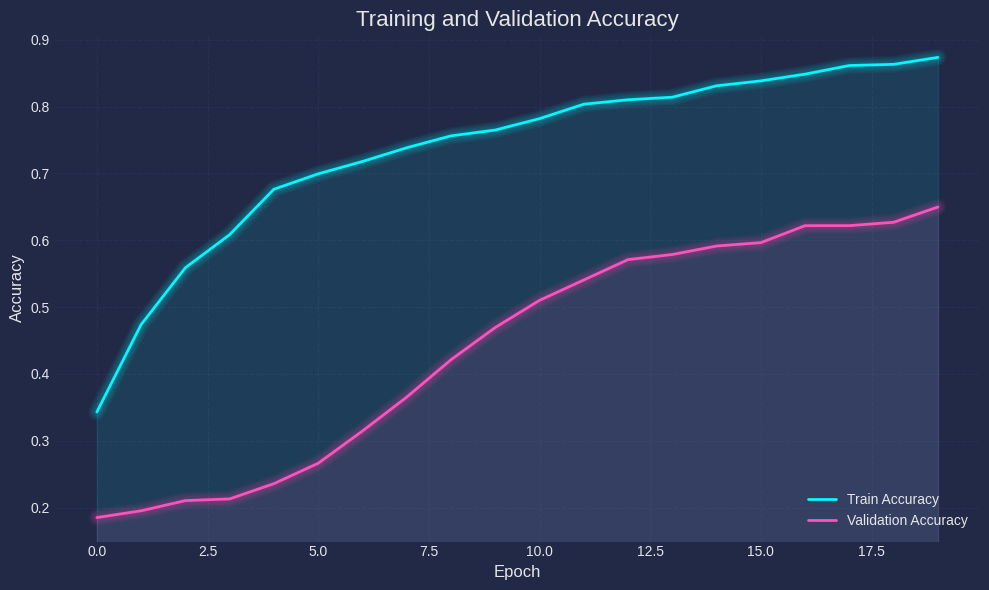

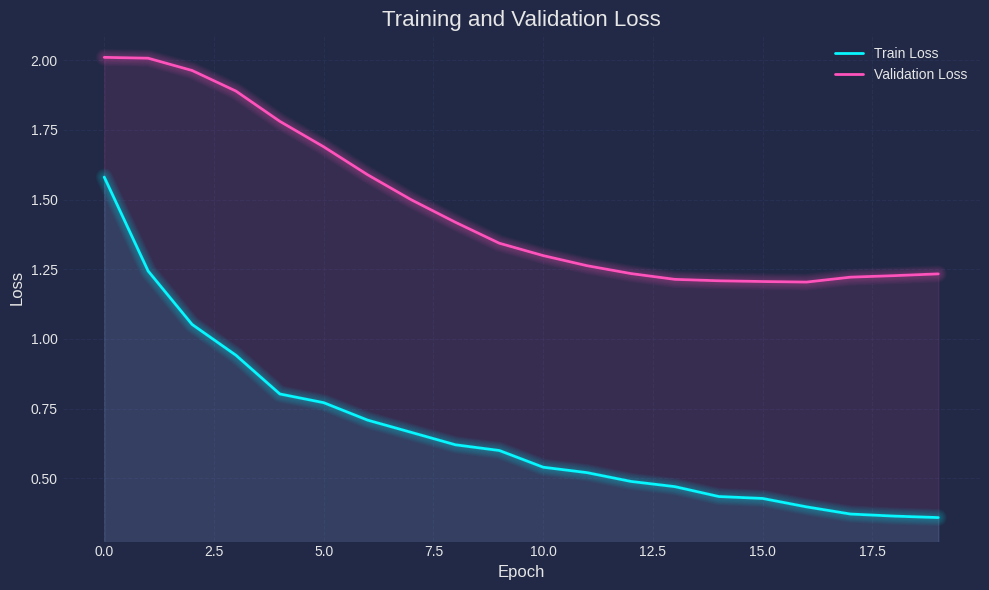

In [ ]:
import matplotlib.pyplot as plt
import mplcyberpunk


plt.style.use("cyberpunk")

# 1) Validation/Train ve Loss Grafikleri
# Accuracy grafiği
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right', fontsize=10)
mplcyberpunk.add_glow_effects()
plt.tight_layout()
plt.show()

# Loss grafiği
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize=10)
mplcyberpunk.add_glow_effects()
plt.tight_layout()
plt.show()

In [ ]:
model.save('base_model_mobileNet.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Gerçek Label: no_tumor
Tahmin Label: no_tumor
Confidence: 0.8168


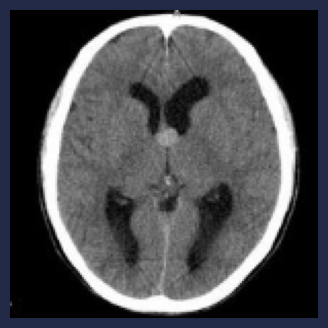

In [ ]:
import numpy as np
import random

# Rastgele bir test örneği seçilir
random_idx = random.randint(0, len(X_test) - 1)
test_image = X_test[random_idx]
true_label = y_test[random_idx]


test_image_expanded = np.expand_dims(test_image, axis=0)

# Tahmin yapılır
prediction = model.predict(test_image_expanded)
predicted_class = np.argmax(prediction, axis=1)[0]
confidence = np.max(prediction)


true_label_class = np.argmax(true_label)
true_label_name = labels[true_label_class]
predicted_label_name = labels[predicted_class]


print(f"Gerçek Label: {true_label_name}")
print(f"Tahmin Label: {predicted_label_name}")
print(f"Confidence: {confidence:.4f}")


plt.figure(figsize=(4, 4))
plt.imshow(test_image.astype('uint8'))
plt.axis('off')
mplcyberpunk.add_glow_effects()
plt.show()

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.3 MB/s eta 0:00:00


In [ ]:
import optuna
from tensorflow.keras.callbacks import EarlyStopping

# öncelikle accuracy'e göre hpo yapılacaktır

def objective(trial):

    # Model oluşturmak
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = False
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    optuna_model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(dropout_rate),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])

    # Modeli derlemek
    optuna_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

    early_stopping = EarlyStopping(
        monitor='val_loss',  # Doğrulama kaybını izler
        patience=3,          # 3 epoch boyunca iyileşme olmazsa durdurur
        restore_best_weights=True,  # En iyi ağırlıkları geri yükler
        verbose=1            # Durdurma mesajını gösterir
    )

    # Modeli eğitir
    history = optuna_model.fit(X_train, y_train, batch_size=batch_size, epochs=10,
                               validation_data=(X_test, y_test),
                               callbacks=[early_stopping], verbose=0)

    # Doğruluğu döndürür
    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)


print("En iyi hiperparametreler:", study.best_params)
print("En iyi validation accuracy:", study.best_value)


best_lr = study.best_params['learning_rate']
best_batch_size = study.best_params['batch_size']
best_dropout = study.best_params['dropout_rate']

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

model_optuna = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(best_dropout),
    Dense(128, activation='relu'),
    Dropout(best_dropout),
    Dense(4, activation='softmax')
])

model_optuna.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_lr),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history_optuna = model_optuna.fit(X_train, y_train, batch_size=best_batch_size, epochs=15,
                               validation_data=(X_test, y_test),
                               callbacks=[early_stopping], verbose=1)

[I 2025-05-01 11:15:08,049] A new study created in memory with name: no-name-d7a5d018-87ad-40ff-a632-4ac578d719c2


Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


[I 2025-05-01 11:15:34,054] Trial 0 finished with value: 0.5609136819839478 and parameters: {'learning_rate': 0.00019339556651960015, 'dropout_rate': 0.4703802563052672, 'batch_size': 32}. Best is trial 0 with value: 0.5609136819839478.


Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


[I 2025-05-01 11:15:58,531] Trial 1 finished with value: 0.6751269102096558 and parameters: {'learning_rate': 0.00020242634185178827, 'dropout_rate': 0.23834056063359033, 'batch_size': 32}. Best is trial 1 with value: 0.6751269102096558.


Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


[I 2025-05-01 11:16:22,932] Trial 2 finished with value: 0.6116751432418823 and parameters: {'learning_rate': 0.00028395551809089073, 'dropout_rate': 0.37440235067989824, 'batch_size': 16}. Best is trial 1 with value: 0.6751269102096558.


Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


[I 2025-05-01 11:16:47,309] Trial 3 finished with value: 0.6319797039031982 and parameters: {'learning_rate': 0.0003859657906008873, 'dropout_rate': 0.22439496468553516, 'batch_size': 32}. Best is trial 1 with value: 0.6751269102096558.


Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


[I 2025-05-01 11:17:10,264] Trial 4 finished with value: 0.4492385685443878 and parameters: {'learning_rate': 5.774050589032241e-05, 'dropout_rate': 0.3980399056890216, 'batch_size': 32}. Best is trial 1 with value: 0.6751269102096558.


Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


[I 2025-05-01 11:17:34,519] Trial 5 finished with value: 0.6015228629112244 and parameters: {'learning_rate': 0.00010721026721108073, 'dropout_rate': 0.26676331323689656, 'batch_size': 16}. Best is trial 1 with value: 0.6751269102096558.


Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


[I 2025-05-01 11:17:58,181] Trial 6 finished with value: 0.5355330109596252 and parameters: {'learning_rate': 8.74760878657372e-05, 'dropout_rate': 0.22544271064786864, 'batch_size': 64}. Best is trial 1 with value: 0.6751269102096558.


Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


[I 2025-05-01 11:18:20,369] Trial 7 finished with value: 0.6522842645645142 and parameters: {'learning_rate': 0.001352821484958436, 'dropout_rate': 0.3643643363638145, 'batch_size': 64}. Best is trial 1 with value: 0.6751269102096558.


Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


[I 2025-05-01 11:18:44,860] Trial 8 finished with value: 0.606598973274231 and parameters: {'learning_rate': 0.00021471303610880895, 'dropout_rate': 0.3184765175860666, 'batch_size': 32}. Best is trial 1 with value: 0.6751269102096558.


Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


[I 2025-05-01 11:19:09,367] Trial 9 finished with value: 0.586294412612915 and parameters: {'learning_rate': 0.0008578729324243057, 'dropout_rate': 0.43207180725216715, 'batch_size': 16}. Best is trial 1 with value: 0.6751269102096558.


En iyi hiperparametreler: {'learning_rate': 0.00020242634185178827, 'dropout_rate': 0.23834056063359033, 'batch_size': 32}
En iyi validation accuracy: 0.6751269102096558
Epoch 1/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - accuracy: 0.4990 - loss: 1.1858 - val_accuracy: 0.4721 - val_loss: 1.3355
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7614 - loss: 0.5925 - val_accuracy: 0.5533 - val_loss: 1.3408
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8131 - loss: 0.4976 - val_accuracy: 0.5736 - val_loss: 1.4630
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8224 - loss: 0.4391 - val_accuracy: 0.6294 - val_loss: 1.5854
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step

Weighted F1 Score (Optuna Model): 0.4250

Classification Report (Optuna Model):
                  precision    recall  f1-score   support

    glioma_tumor       0.67      0.14      0.23       100
        no_tumor       0.39      0.90      0.54       105
meningioma_tumor       0.43      0.23      0.30       115
 pituitary_tumor       0.75      0.69      0.72        74

        accuracy                           0.47       394
       macro avg       0.56      0.49      0.45       394
    weighted avg       0.54      0.47      0.43       394



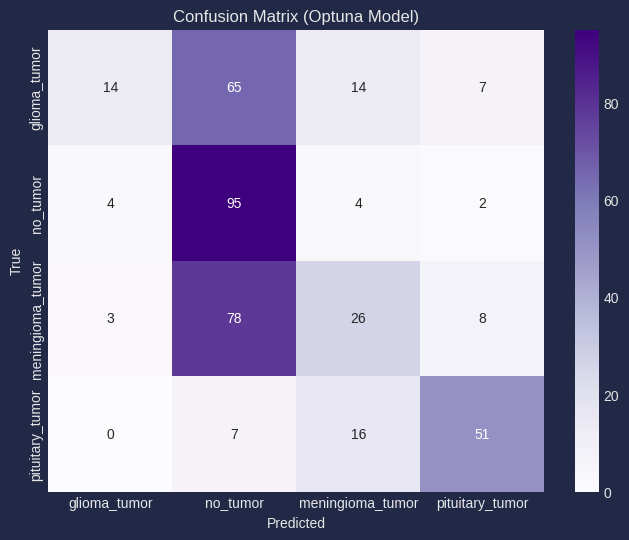

In [ ]:
y_pred = model_optuna.predict(X_test)  # Modelin test verisi üzerindeki tahminleri
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# F1 skoru
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print(f"\nWeighted F1 Score (Optuna Model): {f1:.4f}")

# Classification report
print("\nClassification Report (Optuna Model):")
print(classification_report(y_test_classes, y_pred_classes, target_names=labels))

# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (Optuna Model)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

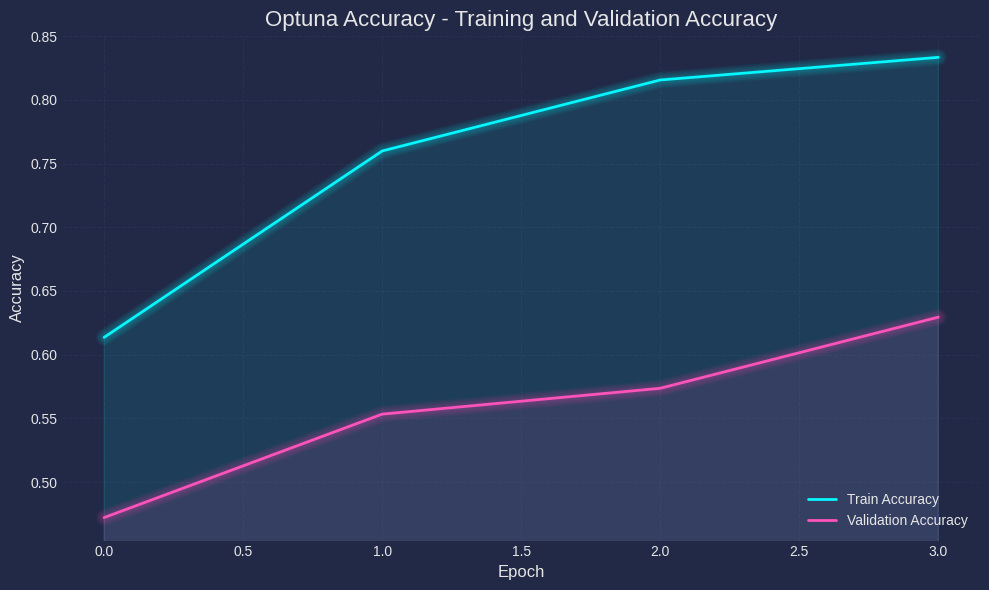

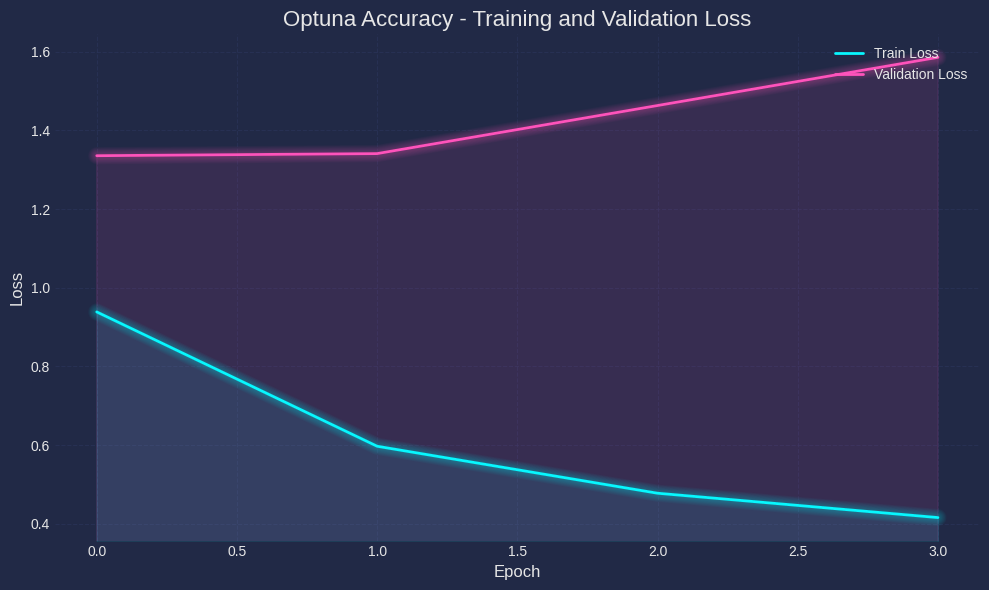

In [ ]:
# Optuna sonuçlarıyla grafikler:
plt.figure(figsize=(10, 6))
plt.plot(history_optuna.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_optuna.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Optuna Accuracy - Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right', fontsize=10)
mplcyberpunk.add_glow_effects()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history_optuna.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_optuna.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Optuna Accuracy - Training and Validation Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize=10)
mplcyberpunk.add_glow_effects()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import f1_score

# Bu bölümde F1 skoruna göre Optuna ile hpo yapılacaktır
def objective(trial):

    # Hiperparametre aralıkları
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = False
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    optuna_f1_model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(dropout_rate),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])

    optuna_f1_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)

    optuna_f1_model.fit(X_train, y_train,
              batch_size=batch_size,
              validation_data=(X_test, y_test),
              epochs=10,
              callbacks=[early_stopping],
              verbose=0)


    y_pred_probs = optuna_f1_model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # F1 skoru (makro ortalama)
    val_f1 = f1_score(y_true, y_pred, average='macro')
    return val_f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("En iyi hiperparametreler:", study.best_params)
print("En iyi validation F1:", study.best_value)


[I 2025-05-01 11:23:14,812] A new study created in memory with name: no-name-56608666-5555-491e-90ee-7b5074c5248b


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step


[I 2025-05-01 11:23:44,566] Trial 0 finished with value: 0.44996845512722183 and parameters: {'learning_rate': 0.002410361773799508, 'dropout_rate': 0.3301443826229026, 'batch_size': 16}. Best is trial 0 with value: 0.44996845512722183.


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step


[I 2025-05-01 11:24:16,044] Trial 1 finished with value: 0.21632041450898337 and parameters: {'learning_rate': 1.596395242777254e-05, 'dropout_rate': 0.34143768530761187, 'batch_size': 16}. Best is trial 0 with value: 0.44996845512722183.


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step


[I 2025-05-01 11:24:44,912] Trial 2 finished with value: 0.3750212721478985 and parameters: {'learning_rate': 0.00012813496575499075, 'dropout_rate': 0.42334664398707034, 'batch_size': 32}. Best is trial 0 with value: 0.44996845512722183.


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step


[I 2025-05-01 11:25:14,666] Trial 3 finished with value: 0.4326099392648421 and parameters: {'learning_rate': 4.517405712594737e-05, 'dropout_rate': 0.353746553670639, 'batch_size': 32}. Best is trial 0 with value: 0.44996845512722183.


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step


[I 2025-05-01 11:25:47,858] Trial 4 finished with value: 0.33516068111032055 and parameters: {'learning_rate': 0.009720320887116303, 'dropout_rate': 0.4321022771275306, 'batch_size': 16}. Best is trial 0 with value: 0.44996845512722183.


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step


[I 2025-05-01 11:26:15,424] Trial 5 finished with value: 0.5208225360057821 and parameters: {'learning_rate': 0.0006938883462882815, 'dropout_rate': 0.20977196847384855, 'batch_size': 64}. Best is trial 5 with value: 0.5208225360057821.


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step


[I 2025-05-01 11:26:47,727] Trial 6 finished with value: 0.4209403445487695 and parameters: {'learning_rate': 0.00010373371300305105, 'dropout_rate': 0.45493482378445105, 'batch_size': 16}. Best is trial 5 with value: 0.5208225360057821.


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step


[I 2025-05-01 11:27:17,814] Trial 7 finished with value: 0.41009642480359787 and parameters: {'learning_rate': 3.897372229245924e-05, 'dropout_rate': 0.4445433004836533, 'batch_size': 32}. Best is trial 5 with value: 0.5208225360057821.


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step


[I 2025-05-01 11:27:47,509] Trial 8 finished with value: 0.3883186623263505 and parameters: {'learning_rate': 3.2166234457223435e-05, 'dropout_rate': 0.33588590685001135, 'batch_size': 16}. Best is trial 5 with value: 0.5208225360057821.


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step


[I 2025-05-01 11:28:15,772] Trial 9 finished with value: 0.4553195895646027 and parameters: {'learning_rate': 6.283044338483265e-05, 'dropout_rate': 0.3633670363121665, 'batch_size': 32}. Best is trial 5 with value: 0.5208225360057821.


En iyi hiperparametreler: {'learning_rate': 0.0006938883462882815, 'dropout_rate': 0.20977196847384855, 'batch_size': 64}
En iyi validation F1: 0.5208225360057821


In [ ]:
best_params = study.best_params

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

model_optuna_f1 = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(best_params['dropout_rate']),
    Dense(128, activation='relu'),
    Dropout(best_params['dropout_rate']),
    Dense(4, activation='softmax')
])

model_optuna_f1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

model_optuna_f1.fit(X_train, y_train,
                 epochs=10,
                 validation_data=(X_test, y_test),
                 callbacks=[early_stopping],
                 verbose=1)

# Test verisi üzerinde F1 skoru

y_test_true = np.argmax(y_test, axis=1)
y_pred_probs = model_optuna_f1.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Sınıflandırma raporu
from sklearn.metrics import classification_report
print(classification_report(y_test_true, y_pred))

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - accuracy: 0.6085 - loss: 0.9704 - val_accuracy: 0.5812 - val_loss: 1.1687
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8103 - loss: 0.4600 - val_accuracy: 0.6574 - val_loss: 1.3293
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8724 - loss: 0.3295 - val_accuracy: 0.7259 - val_loss: 1.4248
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8949 - loss: 0.2691 - val_accuracy: 0.6878 - val_loss: 1.8797
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step
              precision    recall  f1-score   support

           0       0.50      0.22      0.31       100
           1       0.56      0.72      0.63       105
           2       0.53      0.71      0.61       115
           3       0.83      0.66      0.74        74

    accuracy                           0.58       394
   macro avg       0.60      0.58      0

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8712 - loss: 0.3115 - val_accuracy: 0.6624 - val_loss: 1.6614
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8922 - loss: 0.2650 - val_accuracy: 0.6701 - val_loss: 1.9952
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9158 - loss: 0.2307 - val_accuracy: 0.6751 - val_loss: 2.4551
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9252 - loss: 0.1921 - val_accuracy: 0.7411 - val_loss: 2.5282
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


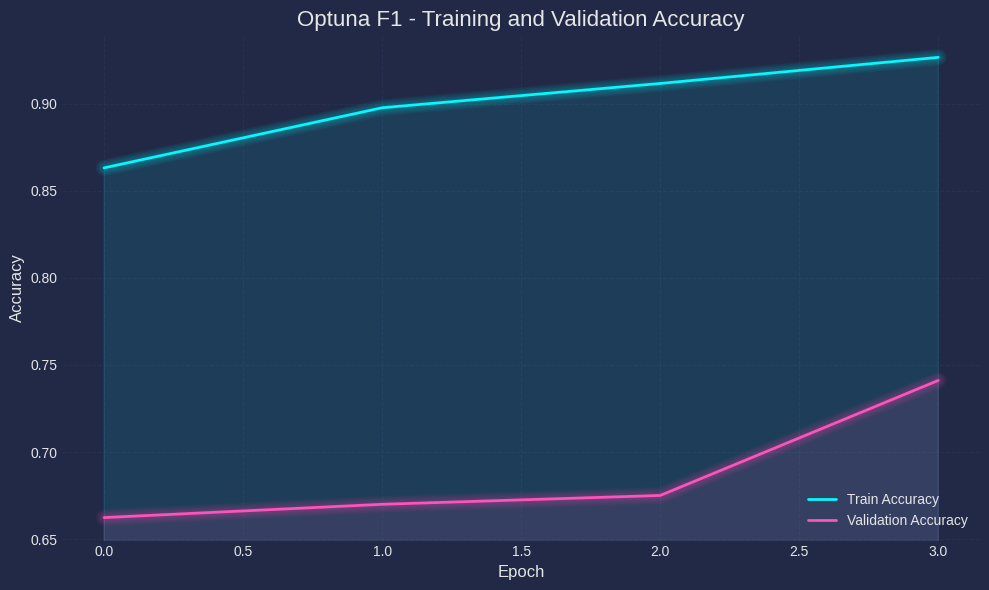

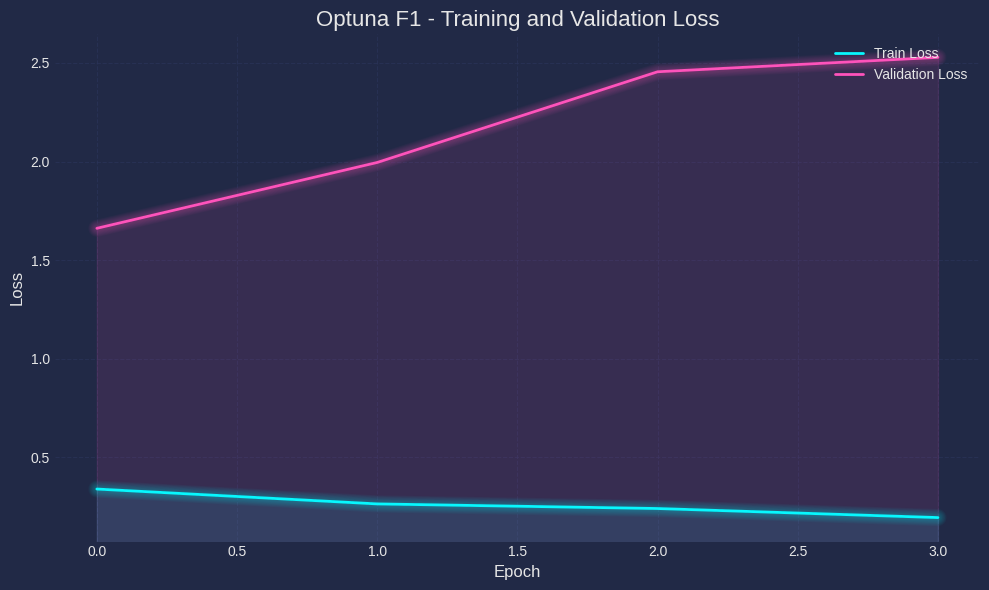

In [ ]:
history_f1 = model_optuna_f1.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Optuna F1 sonuçlarıyla grafikler:
plt.figure(figsize=(10, 6))
plt.plot(history_f1.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_f1.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Optuna F1 - Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right', fontsize=10)
mplcyberpunk.add_glow_effects()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history_f1.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_f1.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Optuna F1 - Training and Validation Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize=10)
mplcyberpunk.add_glow_effects()
plt.tight_layout()
plt.show()


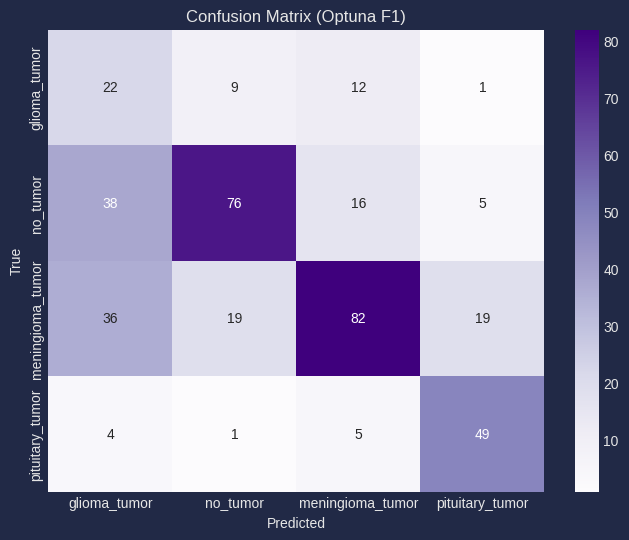

In [ ]:
cm = confusion_matrix(y_pred, y_test_true)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (Optuna F1)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()